# Анализ пользовательского взаимодействия с карточками статей Яндекс.Дзен

**Цели и задачи проекта:** построить дашборд и проанализировать пользовательское взаимодействие с карточками статей сервиса "Яндекс.Дзен"  

**Входные данные:** cырые данные базы данных о событиях взаимодействия пользователей с карточками Яндекс.Дзен. Техническое задание по построению дашборда.

**Обозначения категорий исходных данных:** Исходные данные для проекта содержатся базе данных data-analyst-zen-project-db. Обозначения переменных приведены ниже:

* *record_id* — уникальный идентификатор пользователя,
* *item_topic* — тема карточки,
* *source_topic* — тема источника,
* *age_segment* — возрастная категория,
* *dt* — дата и время,
* *visits* — информация о количестве событий.

**План работы** над проектом включает в себя выполнение следующих шагов:
* *Подключение к базе данных.* Зададаем параметры подключения, формируем строку соединения и формулируем запрос SQL.

* *Импорт данных и изучение общей информации.* На этом этапе получаем общую информацию об имеющихся у нас в распоряжении данных, их типах, полноте и правильности представления. Предварительно оцениваем объем данных, их минимальные и максимальные значения, присутствие пропусков и дубликатов. Дополнительно импортируем и устанавливаем обновления необходимых библиотек. 

* *Подготовка данных.* В этой части работы обращаем пристальное внимание на недостатки исходных данных: переименовываем переменные (названия столбцов) и приводим их названия к единому стандарту. Анализируем пропуски и оцениваем необходимость обработки пропусков в данных. Преобразуем данные в верный тип, проверяем их на присутствие ошибочных значений и обрабатываем дубликаты (если присутствуют) с целью исключения искажений в результатах. Сохраняем датасет в файле dash_visits.csv. 

* *Создание дашборда и презентации.* 

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подключение-к-базе-данных" data-toc-modified-id="Подключение-к-базе-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подключение к базе данных</a></span></li><li><span><a href="#Импорт-данных-и-изучение-общей-информации" data-toc-modified-id="Импорт-данных-и-изучение-общей-информации-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорт данных и изучение общей информации</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Создание-дашборда-и-презентации" data-toc-modified-id="Создание-дашборда-и-презентации-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Создание дашборда и презентации</a></span></li></ul></div>

## Подключение к базе данных

Установим библиотеки анализа и чтения данных из таблиц базы данных (БД):

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt 
import yaml

Создадим подключение к базе данных:

In [2]:
# Задаём параметры подключения к БД
db_config = yaml.safe_load(open('connection_parameters.yml'))


# Формируем строку соединения с БД
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                db_config['pwd'],
                                                db_config['host'],
                                                db_config['port'],
                                                db_config['db'])
# Подключаемся к БД
engine = create_engine(connection_string)

Предварительно ознакомимся с информацией о колонках, формирующих БД: 

In [3]:
query_columns_info = '''
                 SELECT *
                 FROM INFORMATION_SCHEMA.COLUMNS
                 WHERE TABLE_NAME='dash_visits' 
             '''

In [4]:
pd.io.sql.read_sql(query_columns_info, con = engine)

,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,...,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
0,data-analyst-zen-project-db,public,dash_visits,record_id,1,nextval('dash_visits_record_id_seq'::regclass),NO,integer,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
1,data-analyst-zen-project-db,public,dash_visits,item_topic,2,None,YES,character varying,128.0,512.0,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2,data-analyst-zen-project-db,public,dash_visits,source_topic,3,None,YES,character varying,128.0,512.0,...,NO,None,None,None,None,None,NO,NEVER,None,YES
3,data-analyst-zen-project-db,public,dash_visits,age_segment,4,None,YES,character varying,128.0,512.0,...,NO,None,None,None,None,None,NO,NEVER,None,YES
4,data-analyst-zen-project-db,public,dash_visits,dt,5,None,YES,timestamp without time zone,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
5,data-analyst-zen-project-db,public,dash_visits,visits,6,None,YES,integer,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES


## Импорт данных и изучение общей информации

Сформируем SQL-запрос на извлечение всей информации из БД:

In [5]:
query_data = ''' 
            SELECT *
            FROM dash_visits
        ''' 

Выполняем SQL-запрос с указанием индексной колонки и сохраняем результат в датасет:

In [6]:
raw_data = pd.io.sql.read_sql(query_data, con = engine, index_col = 'record_id')

Предварительно ознакомимся с имеющимися датасетом, используя следующий шаблон-функцию:

In [7]:
def general_info(dataset):
    """
    Функция дает краткую информацию о размере датасета и типах данных, а также проверяет на присутствие полных дубликатов
    """
    # оформление комментариев при выводе данных
    class color:
       RED = '\033[91m'
       BOLD = '\033[1m'
       END = '\033[0m'
    
    # Вывод всех колонок датасета из запроса
    print('')
    print(color.RED + color.BOLD + 'Информация, включающая записи датасета:' + color.END)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', 130)
    display(dataset.head())
    
    # Вывод информации о размере датасета, типе данных и пропущенных/минимальных/максимальных значениях 
      
    print(color.RED + color.BOLD + 'Информация о размере датасета, типе данных и пропущенных значениях:' + color.END)
    print('')
    dataset.info()
          
    # Вывод информации о количестве дубликатов
    print('')
    duplicates_amount = dataset.duplicated().sum()
    print(color.RED + color.BOLD + 'Количество полных дубликатов в данных:'+ color.END, duplicates_amount)

In [8]:
general_info(raw_data)


Информация, включающая записи датасета:


,item_topic,source_topic,age_segment,dt,visits
record_id,,,,,
1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1
1040599,Деньги,Авто,18-25,2019-09-24 18:54:00,4
1040600,Деньги,Авто,18-25,2019-09-24 18:55:00,17
1040601,Деньги,Авто,18-25,2019-09-24 18:56:00,27


Информация о размере датасета, типе данных и пропущенных значениях:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30745 entries, 1040597 to 1071341
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   item_topic    30745 non-null  object        
 1   source_topic  30745 non-null  object        
 2   age_segment   30745 non-null  object        
 3   dt            30745 non-null  datetime64[ns]
 4   visits        30745 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.4+ MB

Количество полных дубликатов в данных: 0


## Подготовка данных

Проверим интервал дат и времени:

In [9]:
print(min(raw_data['dt']), max(raw_data['dt']))

2019-09-24 18:28:00 2019-09-24 19:00:00


Сохраним интересующий датасет в файл формата csv:

In [10]:
raw_data.to_csv('dash_visits.csv', encoding='utf-8')

Проверим корректность сохранения файла:

In [11]:
df = pd.read_csv('dash_visits.csv', index_col='record_id')

In [12]:
df.head()

,item_topic,source_topic,age_segment,dt,visits
record_id,,,,,
1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1
1040599,Деньги,Авто,18-25,2019-09-24 18:54:00,4
1040600,Деньги,Авто,18-25,2019-09-24 18:55:00,17
1040601,Деньги,Авто,18-25,2019-09-24 18:56:00,27


Сформируем сводную таблицуи оформим в виде heatmap:

In [13]:
pivot = (
    df.pivot_table(
        index='item_topic',
        columns='source_topic',
        values='visits',
        aggfunc='sum',
        margins=True,
        margins_name='Grand Total')
)

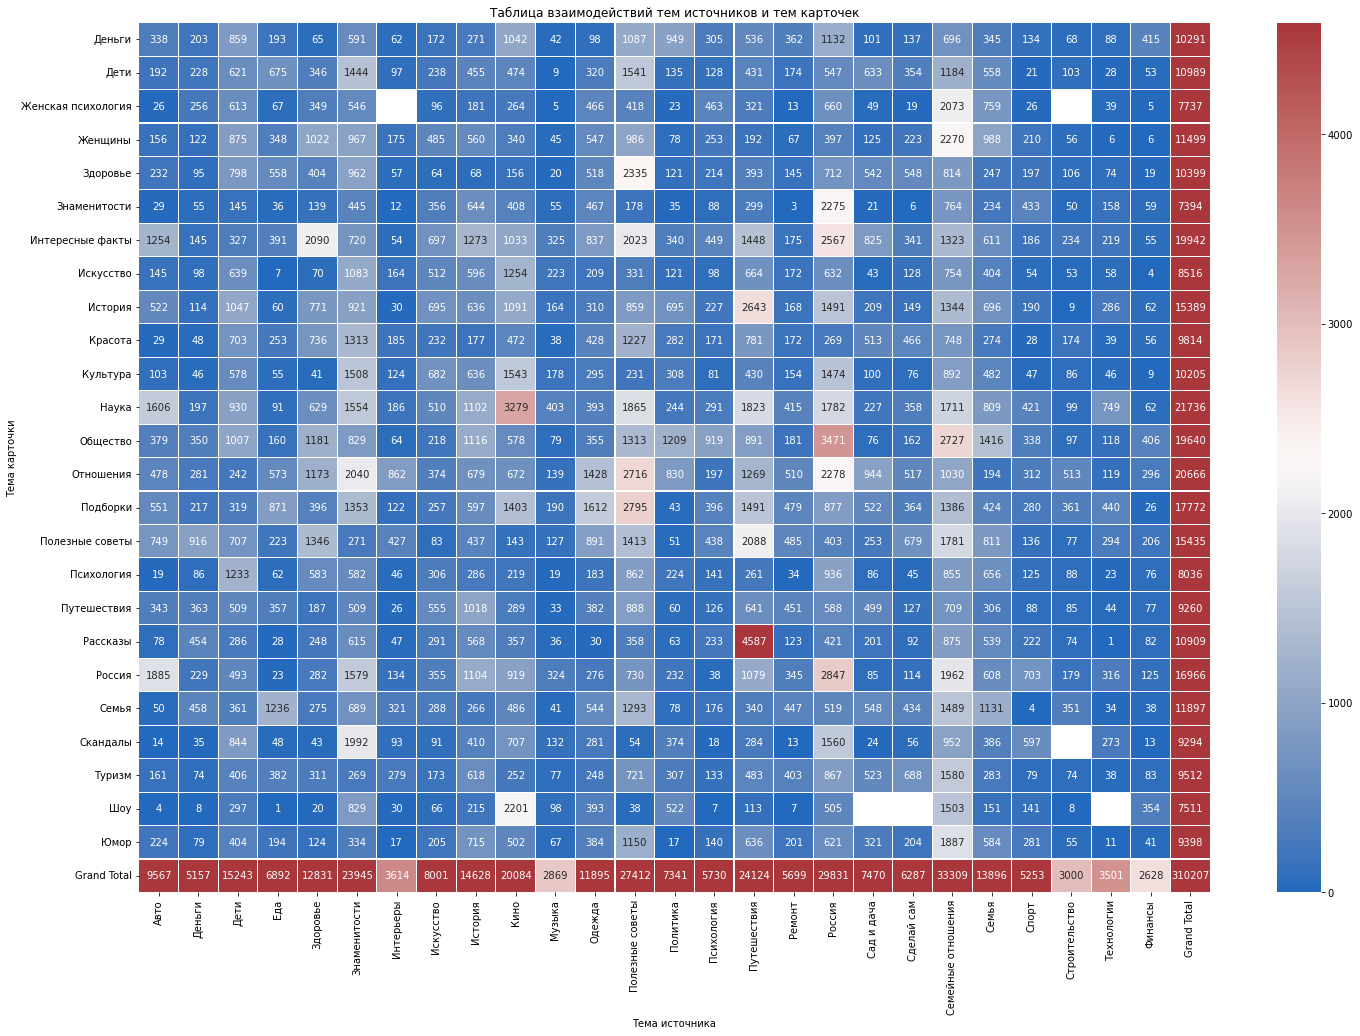

In [14]:
plt.figure(figsize=(24, 16))
g = sns.heatmap(pivot, annot=True, fmt='.0f', vmin=0, vmax=4587, linewidths=.1, cmap='vlag')
g.set_title('Таблица взаимодействий тем источников и тем карточек')
g.set_ylabel('Тема карточки')
g.set_xlabel('Тема источника')
plt.show()

## Создание дашборда и презентации

**Ссылка на дашборд:**
https://public.tableau.com/app/profile/oleg.rofman/viz/dashboard_project_16286884825730/Dashboard

**Ссылка на презентацию:**
https://drive.google.com/file/d/1AsuWhhxbCld27etz9T1xPu_NbmAZBeNZ/view?usp=sharing